<a href="https://colab.research.google.com/github/tanumeena28/Ml-Ass1Q1/blob/main/ml_lab2_que1(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Advertising

In [1]:
from google.colab import files
uploaded = files.upload()

Saving advertising.csv to advertising.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [3]:
df = pd.read_csv('advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [4]:

print("Shape:", df.shape)


print("\nInfo:")
print(df.info())


print("\nUnique values:")
print(df.nunique())

print("\nMissing Values per column: \n", df.isnull().sum())

Shape: (200, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB
None

Unique values:
TV           190
Radio        167
Newspaper    172
Sales        121
dtype: int64

Missing Values per column: 
 TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64


Handling Missing Values

In [5]:
# Replace missing values with column mean
df_mean = df.copy()
for col in df_mean.columns:
    if df_mean[col].isnull().sum() > 0:
        mean_val = df_mean[col].mean()
        df_mean[col].fillna(mean_val, inplace=True)


# Replace missing values with column median
df_median = df.copy()
for col in df_median.columns:
    if df_median[col].isnull().sum() > 0:
        median_val = df_median[col].median()
        df_median[col].fillna(median_val, inplace=True)


# Replace missing values with 0
df_zero = df.copy()
df_zero.fillna(0, inplace=True)

print("\nMissing Values After Filling with Mean:\n", df_mean.isnull().sum())



Missing Values After Filling with Mean:
 TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64


Normalization


In [6]:
# Min-Max Scaling
def min_max_scaling(data):
    scaled = data.copy()
    for col in scaled.select_dtypes(include=[np.number]).columns:
        min_val, max_val = scaled[col].min(), scaled[col].max()
        scaled[col] = (scaled[col] - min_val) / (max_val - min_val)
    return scaled


# Standard Scaling
def standard_scaling(data):
    scaled = data.copy()
    for col in scaled.select_dtypes(include=[np.number]).columns:
        mean_val, std_val = scaled[col].mean(), scaled[col].std()
        scaled[col] = (scaled[col] - mean_val) / std_val
    return scaled

df_minmax = min_max_scaling(df_mean)
df_standard = standard_scaling(df_mean)

print("\nFirst 5 rows after Min-Max Scaling:")
print(df_minmax.head())
print("\nFirst 5 row after standard scaling:")
print(df_standard.head())


First 5 rows after Min-Max Scaling:
         TV     Radio  Newspaper     Sales
0  0.775786  0.762097   0.605981  0.807087
1  0.148123  0.792339   0.394019  0.346457
2  0.055800  0.925403   0.606860  0.409449
3  0.509976  0.832661   0.511873  0.586614
4  0.609063  0.217742   0.510994  0.641732

First 5 row after standard scaling:
         TV     Radio  Newspaper     Sales
0  0.967425  0.979066   1.774493  1.319009
1 -1.194379  1.080097   0.667903 -0.895268
2 -1.512360  1.524637   1.779084 -0.592461
3  0.051919  1.214806   1.283185  0.259184
4  0.393196 -0.839507   1.278593  0.524140


Outlier Detection

In [7]:
def detect_outliers_iqr(data):
    outliers = {}
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index.tolist()
    return outliers

# Detect outliers
outliers = detect_outliers_iqr(df_mean)
print("\nOutlier indices per column:", outliers)

# Remove outliers (rows having any outlier)
outlier_indices = set([i for lst in outliers.values() for i in lst])
df_no_outliers = df_mean.drop(index=outlier_indices)

print(f"\nData shape before removing outliers: {df_mean.shape}")
print(f"Data shape after removing outliers: {df_no_outliers.shape}")
print(f"Outliers removed: {len(outlier_indices)}")




Outlier indices per column: {'TV': [], 'Radio': [], 'Newspaper': [16, 101], 'Sales': []}

Data shape before removing outliers: (200, 4)
Data shape after removing outliers: (198, 4)
Outliers removed: 2


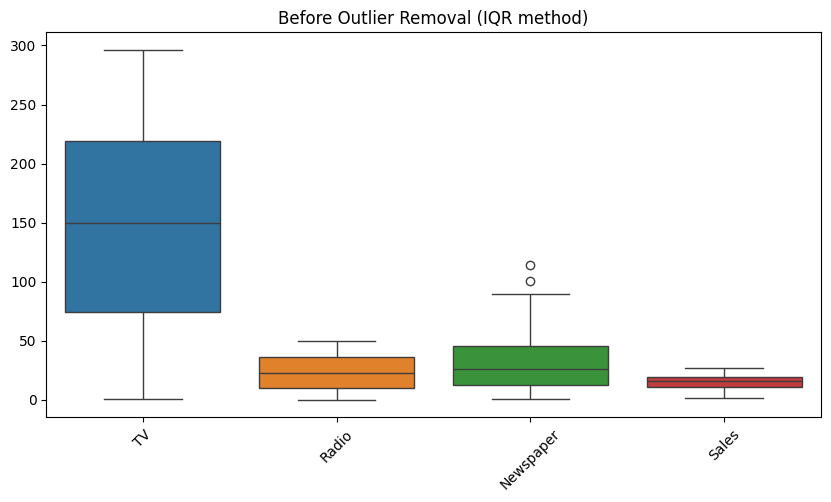

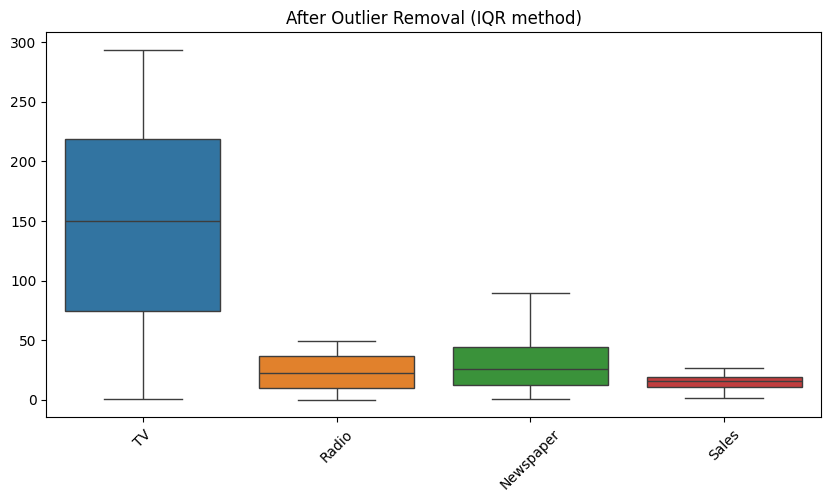

In [8]:
# Before outlier removal
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_mean.select_dtypes(include=[np.number]))
plt.title("Before Outlier Removal (IQR method)")
plt.xticks(rotation=45)
plt.show()

# After outlier removal
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_no_outliers.select_dtypes(include=[np.number]))
plt.title("After Outlier Removal (IQR method)")
plt.xticks(rotation=45)
plt.show()

Linear Regression

In [9]:
from numpy.linalg import inv

# Assuming 'Sales' is the target
X = df_no_outliers.drop(columns='Sales').values
y = df_no_outliers['Sales'].values

# Add bias column
X_b = np.c_[np.ones((X.shape[0], 1)), X]

# Normal Equation: θ = (X^T X)^(-1) X^T y
theta = inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print("\nLinear Regression Coefficients:", theta)

# Predictions
y_pred = X_b.dot(theta)

# R² Score
SS_res = np.sum((y - y_pred) ** 2)
SS_tot = np.sum((y - np.mean(y)) ** 2)
r2_score = 1 - (SS_res / SS_tot)
print(f"R² Score: {r2_score:.4f}")


Linear Regression Coefficients: [4.60019484e+00 5.45445202e-02 1.06916097e-01 8.63138705e-04]
R² Score: 0.9013


In [10]:
# Helper function for missing values
def handle_missing_values(df, method):
    df_copy = df.copy()
    print(f"\n[Missing Value Handling] Method: {method}")

    for col in df_copy.select_dtypes(include=[np.number]).columns:
        missing_count = df_copy[col].isna().sum()
        if missing_count > 0:
            print(f"  - Column '{col}' has {missing_count} missing values")

        if method == "mean":
            fill_value = df_copy[col].mean()
            df_copy[col] = df_copy[col].fillna(fill_value)
            print(f"    Filled with mean = {fill_value:.4f}")
        elif method == "median":
            fill_value = df_copy[col].median()
            df_copy[col] = df_copy[col].fillna(fill_value)
            print(f"    Filled with median = {fill_value:.4f}")

    return df_copy

In [11]:
# Helper function for normalization
def normalize_data(df, method):
    df_copy = df.copy()
    print(f"\n[Normalization] Method: {method}")

    for col in df_copy.select_dtypes(include=[np.number]).columns:
        if method == "minmax":
            min_val, max_val = df_copy[col].min(), df_copy[col].max()
            df_copy[col] = (df_copy[col] - min_val) / (max_val - min_val)
            print(f"  - Column '{col}': min={min_val:.4f}, max={max_val:.4f} → scaled to [0,1]")

        elif method == "standard":
            mean_val, std_val = df_copy[col].mean(), df_copy[col].std()
            df_copy[col] = (df_copy[col] - mean_val) / std_val
            print(f"  - Column '{col}': mean={mean_val:.4f}, std={std_val:.4f} → standardized")

    return df_copy

In [12]:
# Helper function for outlier removal using IQR
def remove_outliers_iqr(df):
    df_copy = df.copy()
    print("\n[Outlier Removal] Using IQR method")

    for col in df_copy.select_dtypes(include=[np.number]).columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before_count = df_copy.shape[0]
        df_copy = df_copy[(df_copy[col] >= lower_bound) & (df_copy[col] <= upper_bound)]
        after_count = df_copy.shape[0]

        print(f"  - Column '{col}': Removed {before_count - after_count} rows outside [{lower_bound:.4f}, {upper_bound:.4f}]")

    return df_copy

In [13]:
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np, pandas as pd

results = []
target = "Sales"

for miss, norm, outliers in product(["mean", "median"], ["minmax", "standard"], [False, True]):
    df_p = handle_missing_values(df, miss)
    if outliers: df_p = remove_outliers_iqr(df_p)
    df_p = normalize_data(df_p, norm)

    X_train, X_test, y_train, y_test = train_test_split(
        df_p.drop(columns=[target]), df_p[target], test_size=0.2, random_state=42
    )

    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Missing": miss, "Norm": norm, "Outliers": outliers,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

results_df = pd.DataFrame(results)
print(results_df.columns)
print("\nBest R²:\n", results_df.loc[results_df["R2"].idxmax()])
print("\nBest RMSE:\n", results_df.loc[results_df["RMSE"].idxmin()])




[Missing Value Handling] Method: mean
    Filled with mean = 147.0425
    Filled with mean = 23.2640
    Filled with mean = 30.5540
    Filled with mean = 15.1305

[Normalization] Method: minmax
  - Column 'TV': min=0.7000, max=296.4000 → scaled to [0,1]
  - Column 'Radio': min=0.0000, max=49.6000 → scaled to [0,1]
  - Column 'Newspaper': min=0.3000, max=114.0000 → scaled to [0,1]
  - Column 'Sales': min=1.6000, max=27.0000 → scaled to [0,1]

[Missing Value Handling] Method: mean
    Filled with mean = 147.0425
    Filled with mean = 23.2640
    Filled with mean = 30.5540
    Filled with mean = 15.1305

[Outlier Removal] Using IQR method
  - Column 'TV': Removed 0 rows outside [-142.3000, 435.5000]
  - Column 'Radio': Removed 0 rows outside [-29.8500, 76.3500]
  - Column 'Newspaper': Removed 2 rows outside [-35.7750, 93.6250]
  - Column 'Sales': Removed 0 rows outside [-0.9625, 30.9375]

[Normalization] Method: minmax
  - Column 'TV': min=0.7000, max=293.6000 → scaled to [0,1]
  - Col

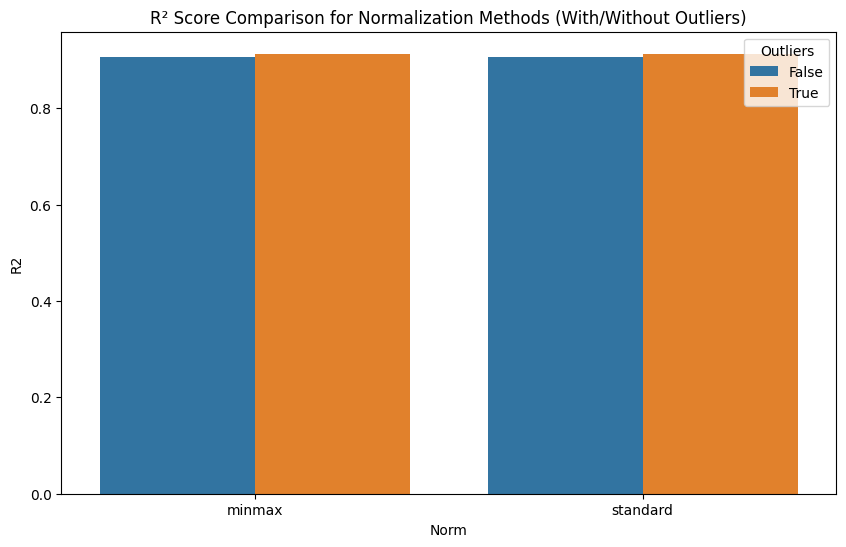

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Norm", y="R2", hue="Outliers")
plt.title("R² Score Comparison for Normalization Methods (With/Without Outliers)")
plt.show()


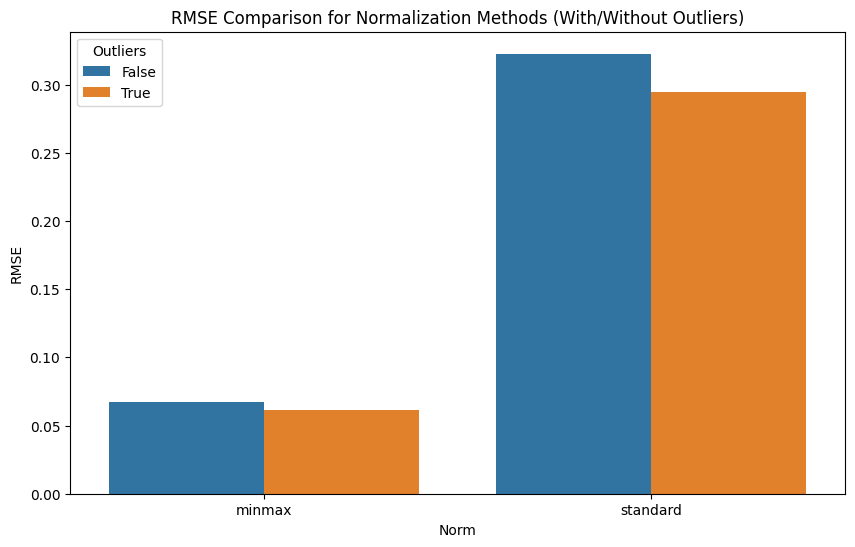

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Norm", y="RMSE", hue="Outliers")
plt.title("RMSE Comparison for Normalization Methods (With/Without Outliers)")
plt.show()

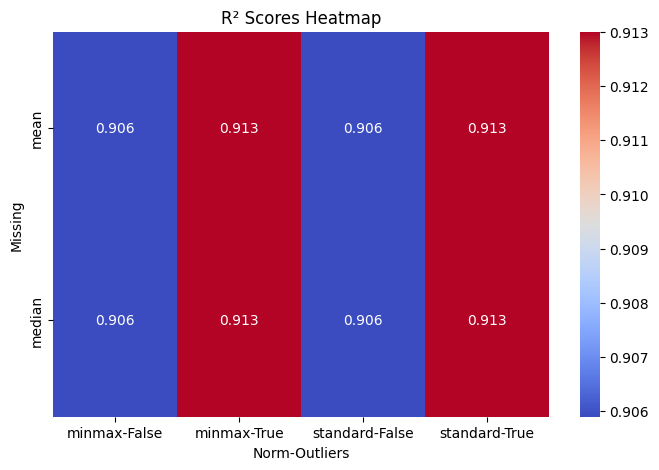

In [16]:
# Heatmap for R²
pivot_r2 = results_df.pivot_table(
    index="Missing",
    columns=["Norm", "Outliers"],
    values="R2"
)
plt.figure(figsize=(8,5))
sns.heatmap(pivot_r2, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("R² Scores Heatmap")
plt.show()